<br>

### 음성데이터 추가

<br>

In [1]:
"""
데이터 준비
$ wget https://aiffelstaticdev.blob.core.windows.net/dataset/speech_wav_8000.npz
"""

"""
1000 Hz 신호를 저장한 wav 파일입니다.
Sample rate 는 48000 Hz, 즉 1초 재생하는데 필요한 Sample 수는 48000개입니다.
모든 샘플은 -1 ~ 1 사이의 정해진 bits per sample의 값으로 표현됩니다.
"""

import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("✅")

✅


In [2]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)
print("✅")

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)
✅


In [3]:
"""
샘플 데이터로 데이터 확인
"""

import IPython.display as ipd
import random

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  50097
Wave data shape :  (8000,)
label :  ['silence']


<br>

### Label data 처리

<br>

In [4]:
"""
단어의 정답은 Text 형태로 이뤄져있습니다.
학습을 위해서는 Text 데이터를 학습가능한 형태로 만들어줘야 합니다.
"""

# label에 포함되지 않는 데이터들은 'unknown'과 'silence'로 분류되어 있음
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)


# Text 데이터를 index 데이터로 변환 (key:value 쌍으로)
new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [5]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

print(label_data)
print(len(label_data))

[ 3  3  3 ... 11 11 11]
50620


<br>

### Train / Test 데이터셋 분리

<br>

In [6]:
"""
sklearn으로 train셋과 test셋 분리
"""

from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])
print("✅")

[[ 2.3963639e-04  7.8675558e-04  7.8440696e-04 ...  7.0295343e-04
   4.9144594e-04  5.0215033e-04]
 [ 2.2135153e-02  3.4355827e-02  2.7554033e-02 ... -2.2259420e-02
  -2.3079382e-02 -2.9926768e-02]
 [ 3.3478206e-03  4.8203650e-03  6.0471768e-05 ...  2.6089242e-03
   2.1077110e-03 -1.9154788e-03]
 ...
 [ 5.0939294e-04  1.5109043e-03  2.5726217e-03 ...  2.2586557e-04
  -1.3764207e-03 -6.7795359e-04]
 [ 6.1651310e-03  1.5652407e-02  1.1633516e-02 ... -8.8950014e-03
  -7.6976838e-03 -9.0062385e-03]
 [-9.6912291e-03 -5.3087939e-03  7.4155699e-03 ... -1.8384401e-02
  -5.4885251e-03  8.3046232e-04]]
✅


In [7]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (45558, 8000, 1)
train labels :  (45558,)
test data :  (5062, 8000, 1)
test labels :  (5062,)
✅


<br>

### 하이퍼파라미터 세팅

<br>

In [8]:
"""
학습을 위한 하이퍼파라미터 설정
모델 체크포인트 저장을 위한 경로 설정
( 이후에 모델 체크포인트 Callback 함수를 설정하거나 모델을 불러올 때 사용 )
"""

batch_size = 32                     # batch_size=32, max_epochs=10으로 세팅한 경우라면 30분 가량 소요
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/ssac29/aiffel/speech_recognition/models/wav'

<br>

### 데이터 전처리

<br>

tf.data.Dataset을 이용해서 데이터셋을 구성하겠습니다. Tensorflow에 포함된 이 데이터셋 관리 패키지는 데이터셋 전처리, 배치처리 등을 쉽게 할 수 있도록 해 줍니다. 자주 사용하게 되니 사용법을 잘 익혀 둡시다.

tf.data.Dataset.from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용할 수 있습니다.

map 함수는 dataset이 데이터를 불러올때마다 동작시킬 데이터 전처리 함수를 매핑해 주는 역할을 합니다. 첫번째 map 함수는 from_tensor_slice 에 입력한 튜플 형태로 데이터를 받으며 return 값으로 어떤 데이터를 반환할지 결정합니다.
map 함수는 중첩해서 사용이 가능합니다.

<br>

In [9]:
"""
데이터 전처리 함수 작성 ( map 함수에 넘겨주기 위해 )
"""

def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


In [10]:
"""
tf.data.Dataset 함수를 구성
"""


import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
                                            # batch()는 dataset에서 제공하는 튜플 형태의 데이터를 얼마나 가져올지 결정하는 함수
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
✅


<br>

### Model construction &ensp; : Wave classification 모델 구현

<br>

In [11]:
"""
Model
Audio 데이터는 1차원 데이터이기 때문에 데이터 형식에 맞도록 모델을 구성
Conv1D layer를 이용해서 모델을 구성
Conv, batch norm, dropout, dense layer 등을 이용해 모델을 구성
"""

from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, 1))      # input data로 1차원 binary 데이터의 (sp, 1)

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8000, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8000, 32)          9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4000, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4000, 64)          18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4000, 64)          36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2000, 64)          0     

In [12]:
"""
Loss
라벨이 될 수 있는 12개의 단어 class를 구분하기 위해서는 multi-class classification이 필요
이를 위한 Loss로 Categorical Cross-Entropy loss를 사용
"""

optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


<br>

### 모델 학습

<br>

__Callback__ <br>

- model.fit 함수를 이용할 때, callback 함수를 이용해서 학습 중간 중간 원하는 동작을 하도록 설정할 수 있습니다. <br>
- 모델을 재사용하기위해서 모델 가중치를 저장하는 callback 함수를 추가해보겠습니다.

In [13]:
"""
Model Checkpoint callback은 
모델을 학습을 진행하며, fit 함수내 다양한 인자를 지정해 모니터하며 동작하게 설정할 수 있습니다.
현재 모델은 validation loss를 모니터하며, loss가 낮아지면 모델 파라미터를 저장하도록 구성되어 있습니다.
"""

# 하이퍼파라미터 세팅의 checkpoint_dir 사용

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [14]:
#30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 1.3975 - accuracy: 0.5419
Epoch 00001: val_loss improved from inf to 1.14683, saving model to /home/ssac29/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 166s 117ms/step - loss: 1.3975 - accuracy: 0.5419 - val_loss: 1.1468 - val_accuracy: 0.6157
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.7946 - accuracy: 0.7546
Epoch 00002: val_loss improved from 1.14683 to 0.75176, saving model to /home/ssac29/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 168s 118ms/step - loss: 0.7946 - accuracy: 0.7546 - val_loss: 0.7518 - val_accuracy: 0.7526
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.5585 - accuracy: 0.8301
Epoch 00003: val_loss improved from 0.75176 to 0.66338, saving model to /home/ssac29/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 169s 119ms/step - loss: 0

<br>

### 학습결과 plot

<br>

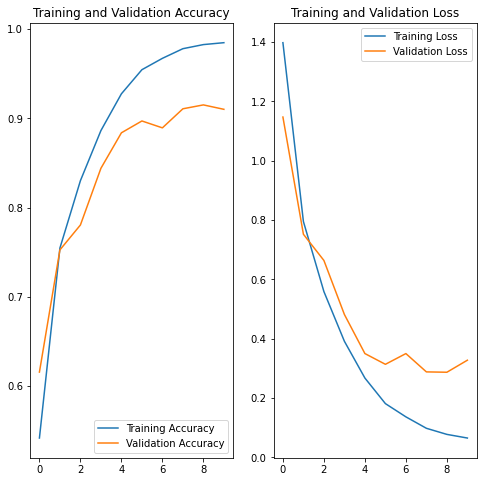

✅


In [15]:
"""
model.fit 함수는 학습 동안의 결과를 return해줍니다.
return 값을 기반으로 loss와 accuracy를 그래프로 표현하겠습니다.
fit 함수에서 전달 받은 Loss와 Accuracy의 값을 이용해 모델이 어떻게 학습되고 있는지 볼 수 있습니다.
train loss와 val_loss의 차이가 커지는 경우 오버피팅이 일어나는 것이기 때문에 이를 수정할 필요가 있습니다.

출력된 그래프를 기반으로 모델의 학습이 어떻게 진행됐는지 확인
"""

import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

<br>

### 모델 평가 Evaluation

<br>

In [16]:
"""
Test dataset을 이용해서 모델의 성능을 평가합니다.
"""

# 실습삼아 checkpoint callback 함수가 저장한 weight를 다시 불러와서 테스트
model_wav.load_weights(checkpoint_dir)

# Test data을 이용하여 모델의 예측값과 실제값이 얼마나 일치하는지 확인
results = model_wav.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

159/159 [==============================] - 12s 73ms/step - loss: 0.2863 - accuracy: 0.9151
loss value: 0.286
accuracy value: 91.5053%


<br>

### 모델 테스트 Test

<br>

In [17]:
"""
Test data 셋을 골라 직접 들어보고 모델의 예측이 맞는지 확인
"""

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  down


In [18]:
"""
위에서 확인해본 테스트셋의 라벨과 우리 모델의 실제 prediction 결과를 비교
"""

if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: down(Correct!)
✅
